### Outline

0. Load Data and Restore results
<br />
<br />
1. Stabilization for linear transformations
<br />
<br />
2. Import packages and Load data
<br />
<br />
3. QC and preprocessing
<br />
<br />
4. Function: identify spatially variable genes
<br />
<br />
5. Function: gene expression enhancement
<br />
<br />
6. Function: characterize functional tissue units

SpaGFT is a python package to analyze spatial transcriptomics data via graph Fourier transform. To install SpaGFT, the python version is required to be >= 3.7. You can check your python version by:

In [1]:
import platform
platform.python_version()

'3.8.20'

## Stage 0：Load Data and Restore results
Apply SpaGFT on the loaded data and compare SVG list output with the SVG list in the atlas 

In [2]:
# Import stage
from stage_0_setup import stage_0_main as s0
# Plotting
CELL_DIAMETER = 7 

### Andersson

In [3]:
results_andersson = s0.run_stage_0_pipeline(slide_id="Human_Breast_Andersson_10142021_ST_A1", 
                         tech="ST")

--- Stage 0 Pipeline | Slide: Human_Breast_Andersson_10142021_ST_A1 ---
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 346 spots x 15045 genes.

[INFO] Fetching reference SVG list for SpaGFT...
Loading SVG list from local file: C:\mnt\data\SpaGFT-Research\results\atlas_results\Human_Breast_Andersson_10142021_ST_A1_SpaGFT_SVG.csv
[SUCCESS] Retrieved 100 reference SVGs.

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

RESULTS COMPARISON (Top 100 SVGs)
Jaccard Index: 0.7857
Overlap: 88


### Maynard

In [4]:
results_maynard = s0.run_stage_0_pipeline(slide_id="Human_Brain_Maynard_02082021_Visium_151676",
                        tech = "Visium")

--- Stage 0 Pipeline | Slide: Human_Brain_Maynard_02082021_Visium_151676 ---
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 3460 spots x 33538 genes.

[INFO] Fetching reference SVG list for SpaGFT...
Loading SVG list from local file: C:\mnt\data\SpaGFT-Research\results\atlas_results\Human_Brain_Maynard_02082021_Visium_151676_SpaGFT_SVG.csv
[SUCCESS] Retrieved 100 reference SVGs.

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

RESULTS COMPARISON (Top 100 SVGs)
Jaccard Index: 0.9231
Overlap: 96


### Breast 10x

In [5]:
results_breast_10x = s0.run_stage_0_pipeline(slide_id="Human_Breast_10X_06092021_Visium",
                        tech = "Visium")

--- Stage 0 Pipeline | Slide: Human_Breast_10X_06092021_Visium ---
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 2518 spots x 17943 genes.

[INFO] Fetching reference SVG list for SpaGFT...
Loading SVG list from local file: C:\mnt\data\SpaGFT-Research\results\atlas_results\Human_Breast_10X_06092021_Visium_SpaGFT_SVG.csv
[SUCCESS] Retrieved 100 reference SVGs.

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

RESULTS COMPARISON (Top 100 SVGs)
Jaccard Index: 0.9608
Overlap: 98


### GS

In [6]:
results_breast_10x = s0.run_stage_0_pipeline(slide_id="GSE213688_GSM6592060",
                        tech = "Visium")

--- Stage 0 Pipeline | Slide: GSE213688_GSM6592060 ---
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 1295 spots x 36601 genes.

[INFO] Fetching reference SVG list for SpaGFT...
Loading SVG list from local file: C:\mnt\data\SpaGFT-Research\results\atlas_results\GSE213688_GSM6592060_SpaGFT_SVG.csv
[SUCCESS] Retrieved 100 reference SVGs.

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

RESULTS COMPARISON (Top 100 SVGs)
Jaccard Index: 0.8182
Overlap: 90


## Stage 1：Stabilization for linear transformations

### Rotation

In [1]:
# Import stage
from stage_1_lin_trns import stage_1_main as s1


=== Stage 1: Rotation Stability Analysis | Slide: Human_Breast_Andersson_10142021_ST_A1 ===
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 346 spots x 15045 genes.

Running Baseline (0°)...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

Processing Angle: 30°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 1.0000 | Spearman: 1.0000

Processing Angle: 45°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 1.0000 | Spearman: 1.0000

Processing Angle: 60°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 1.0000 | Spearman: 1.0000

Processing Angle: 90°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 1.0000 | Spearman: 1.0000

Processing Angle: 180°...

[INFO] Running local SpaGFT implementation...
[INFO] F

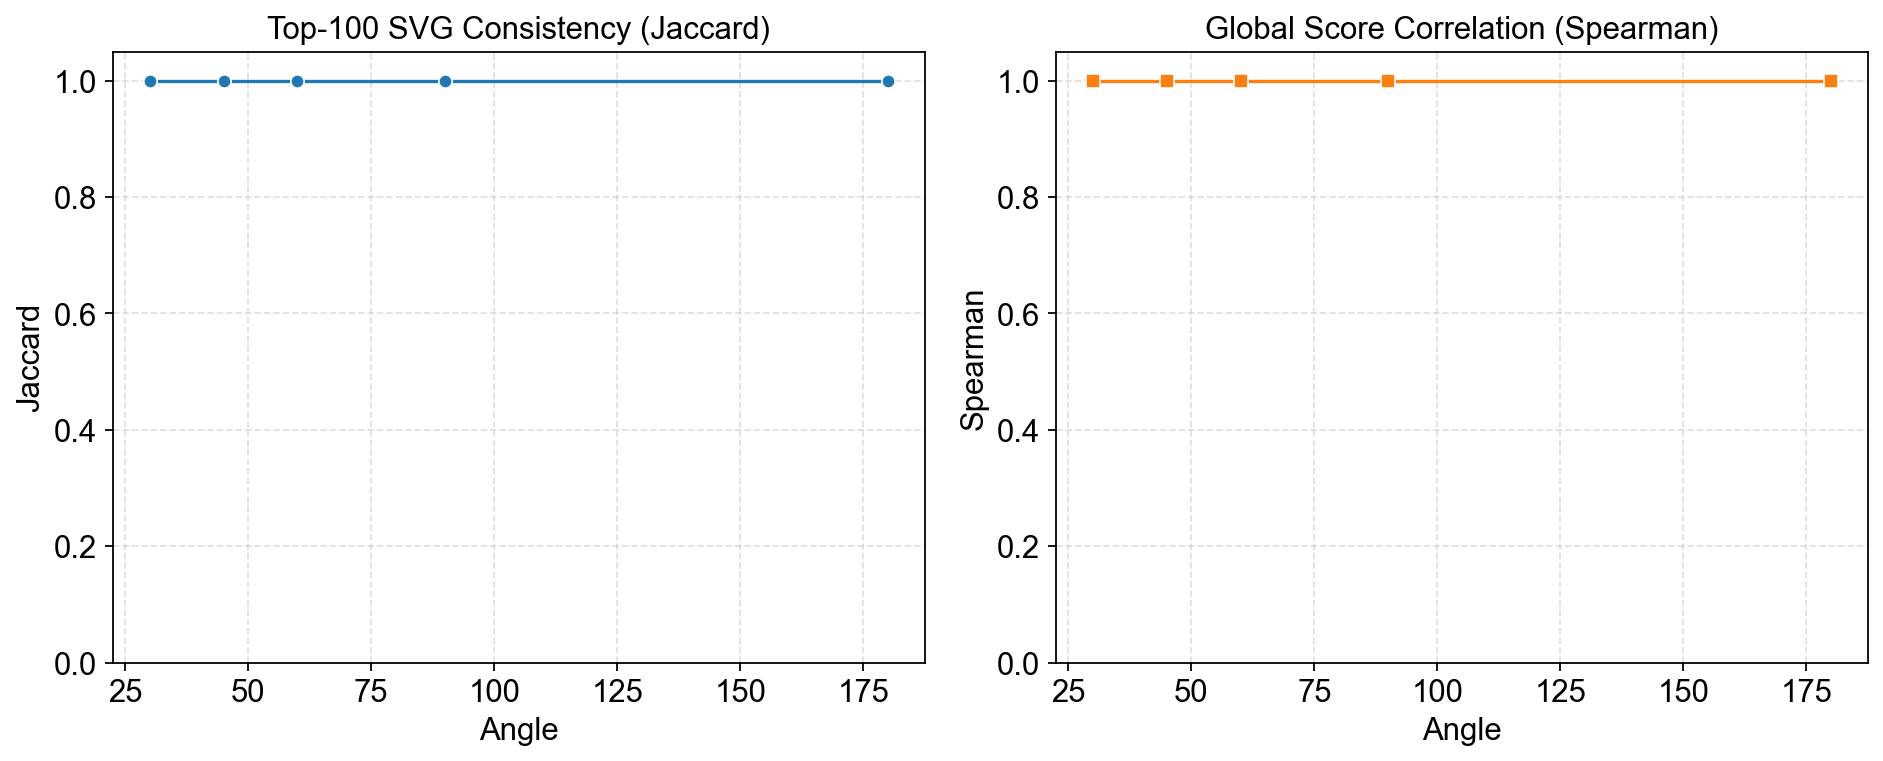

,Angle,Jaccard,Overlap,Spearman
0,30,1.0,100,1.0
1,45,1.0,100,1.0
2,60,1.0,100,1.0
3,90,1.0,100,1.0
4,180,1.0,100,1.0


In [8]:
s1.run_rotation_stability_test()

=== Stage 1: Rotation Stability Analysis | Slide: Human_Brain_Maynard_02082021_Visium_151676 ===
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 3460 spots x 33538 genes.

Running Baseline (0°)...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

Processing Angle: 30°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9231 | Spearman: 0.9960

Processing Angle: 45°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9608 | Spearman: 0.9983

Processing Angle: 60°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9417 | Spearman: 0.9985

Processing Angle: 90°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9417 | Spearman: 0.9966

Processing Angle: 180°...

[INFO] Running local SpaGFT implementation...
[I

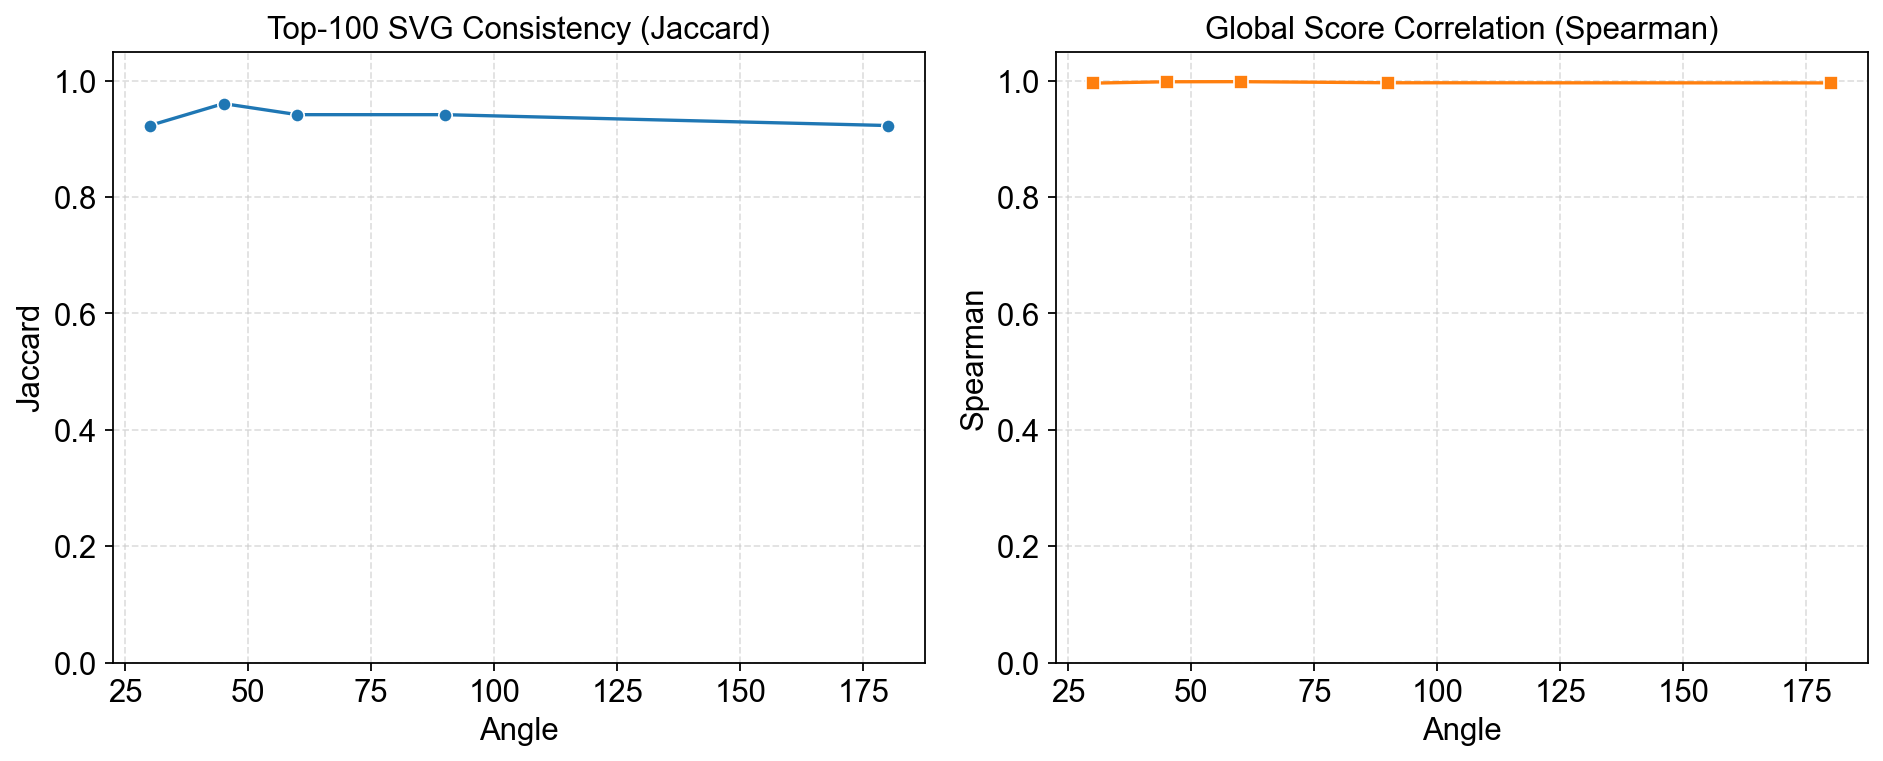

,Angle,Jaccard,Overlap,Spearman
0,30,0.923077,96,0.995971
1,45,0.960784,98,0.998317
2,60,0.941748,97,0.998475
3,90,0.941748,97,0.996594
4,180,0.923077,96,0.996337


In [9]:
s1.run_rotation_stability_test(slide_id="Human_Brain_Maynard_02082021_Visium_151676",
                        tech = "Visium")

=== Stage 1: Rotation Stability Analysis | Slide: Human_Breast_10X_06092021_Visium ===
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 2518 spots x 17943 genes.

Running Baseline (0°)...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

Processing Angle: 30°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9231 | Spearman: 0.9790

Processing Angle: 45°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9231 | Spearman: 0.9846

Processing Angle: 60°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9048 | Spearman: 0.9869

Processing Angle: 90°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9608 | Spearman: 0.9888

Processing Angle: 180°...

[INFO] Running local SpaGFT implementation...
[INFO] Finis

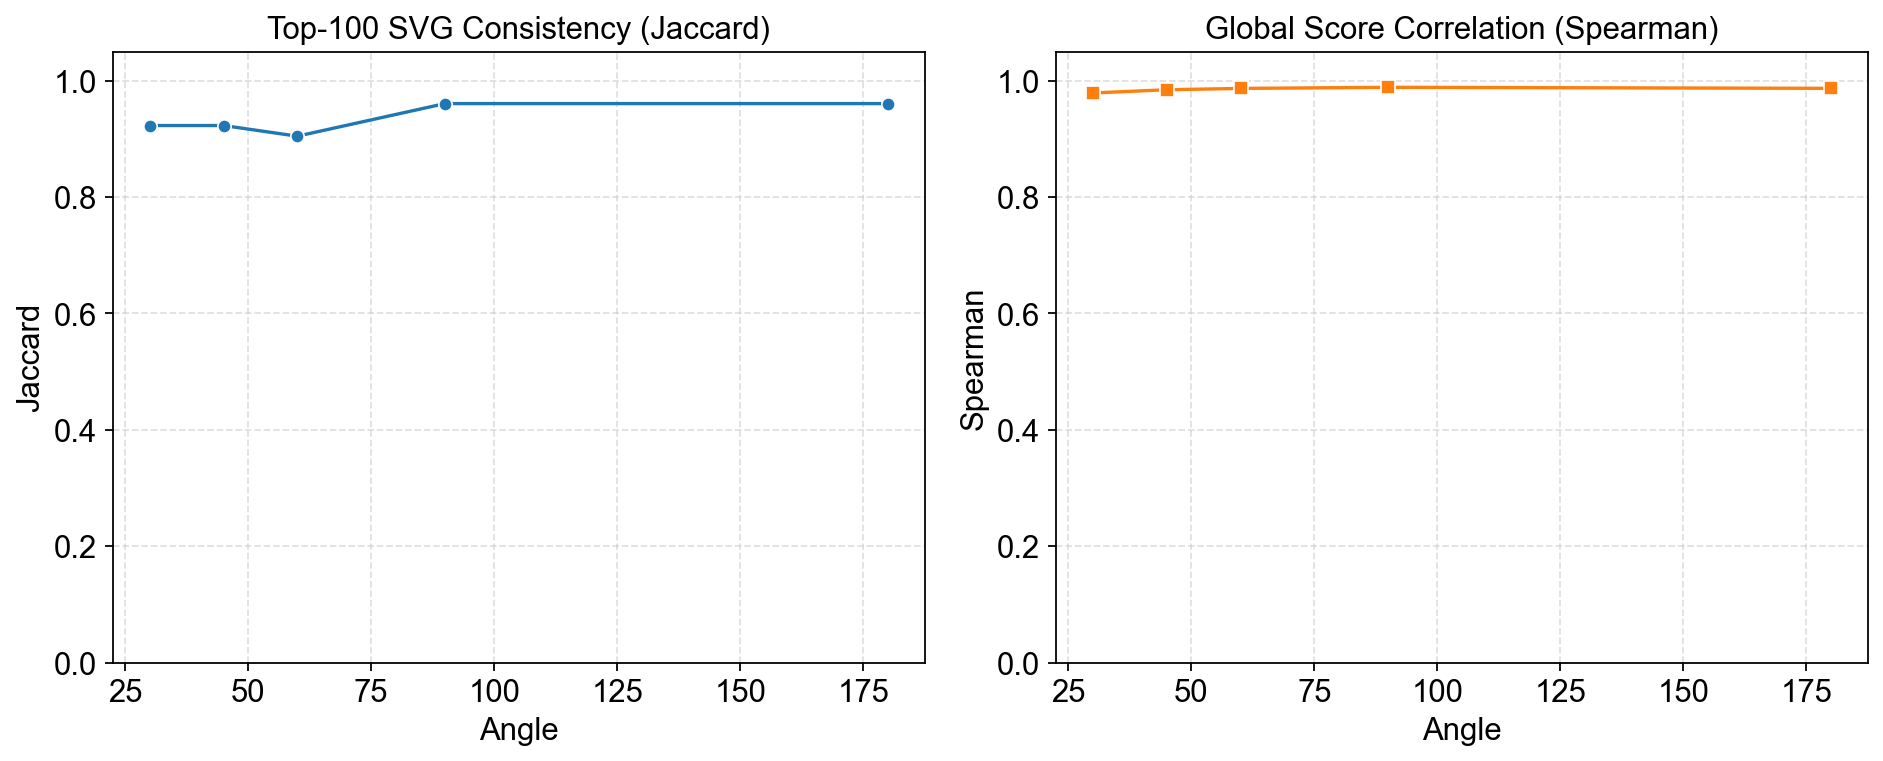

,Angle,Jaccard,Overlap,Spearman
0,30,0.923077,96,0.979042
1,45,0.923077,96,0.984577
2,60,0.904762,95,0.986870
3,90,0.960784,98,0.988779
4,180,0.960784,98,0.986994


In [10]:
s1.run_rotation_stability_test(slide_id="Human_Breast_10X_06092021_Visium",
                        tech = "Visium")

=== Stage 1: Rotation Stability Analysis | Slide: GSE213688_GSM6592060 ===
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 1295 spots x 36601 genes.

Running Baseline (0°)...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

Processing Angle: 30°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9417 | Spearman: 0.9821

Processing Angle: 45°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.8692 | Spearman: 0.9766

Processing Angle: 60°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9417 | Spearman: 0.9675

Processing Angle: 90°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

  -> Jaccard: 0.9608 | Spearman: 0.9878

Processing Angle: 180°...

[INFO] Running local SpaGFT implementation...
[INFO] Finished running 

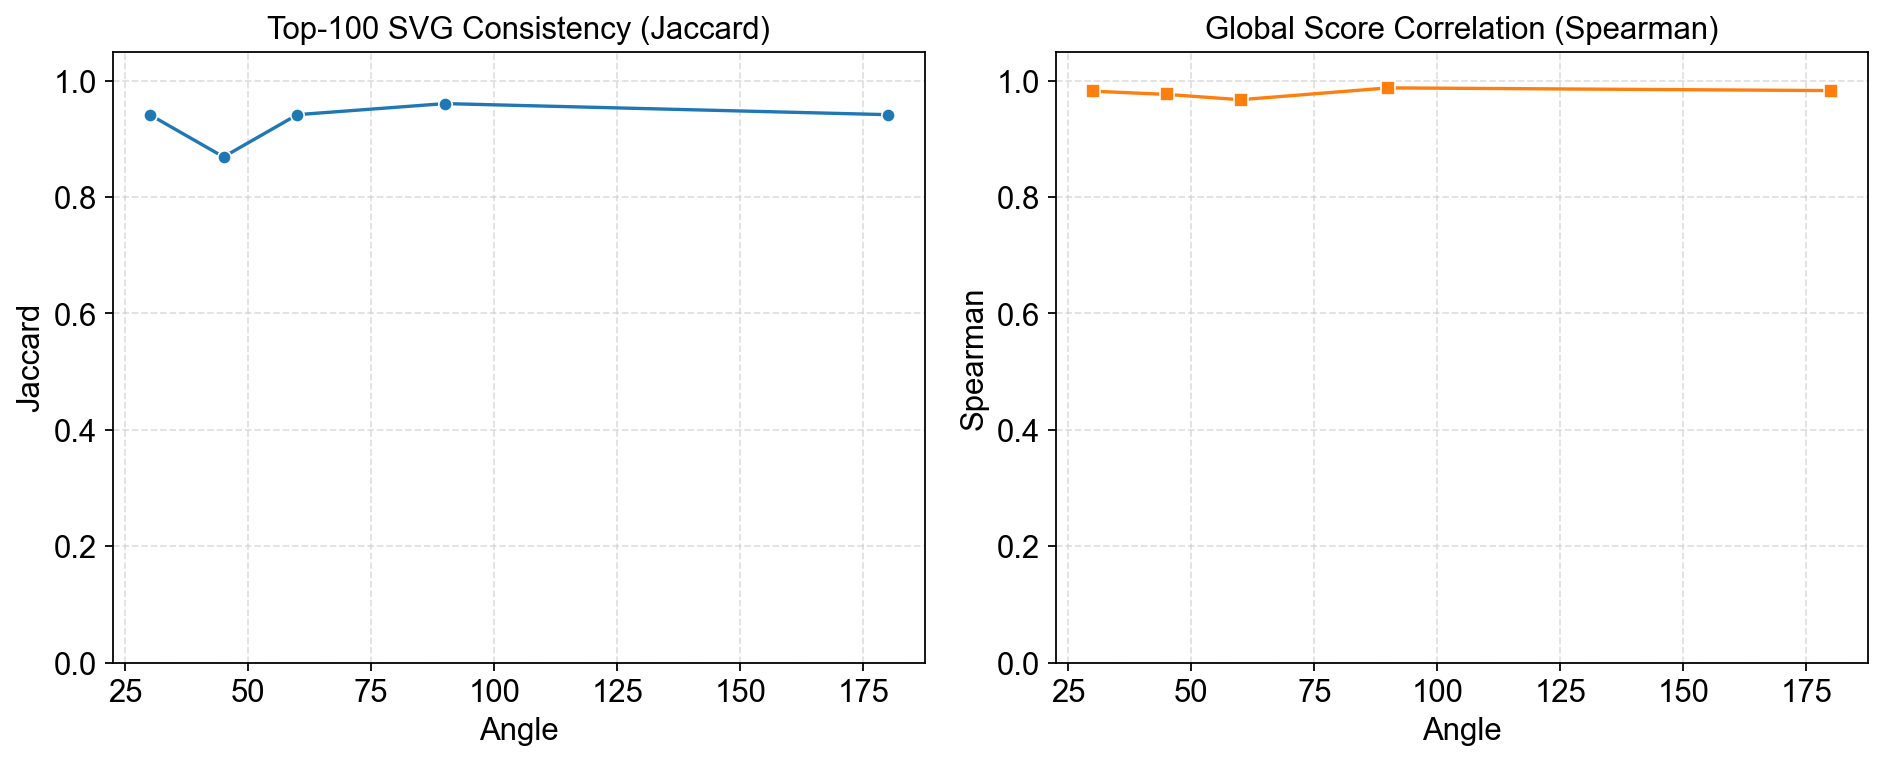

,Angle,Jaccard,Overlap,Spearman
0,30,0.941748,97,0.982103
1,45,0.869159,93,0.976590
2,60,0.941748,97,0.967455
3,90,0.960784,98,0.987797
4,180,0.941748,97,0.983142


In [11]:
s1.run_rotation_stability_test(slide_id="GSE213688_GSM6592060",
                        tech = "Visium")

### Andersson

=== Stage 1: Transformation Stability Analysis | Slide: Human_Breast_Andersson_10142021_ST_A1 ===
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 346 spots x 15045 genes.

[INFO] Preprocessing AnnData...
[INFO] Preprocessing complete.

--- Running Baseline (Original Data) ---

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

Processing Scenario: Rotate 30°
  Params: Angle=30, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 1.0000 | Spearman: 1.0000

Processing Scenario: Rotate 45°
  Params: Angle=45, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 1.0000 | Spearman: 1.0000

Processing Scenario: Rotate 90°
  Params: Angle=90, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 1.0

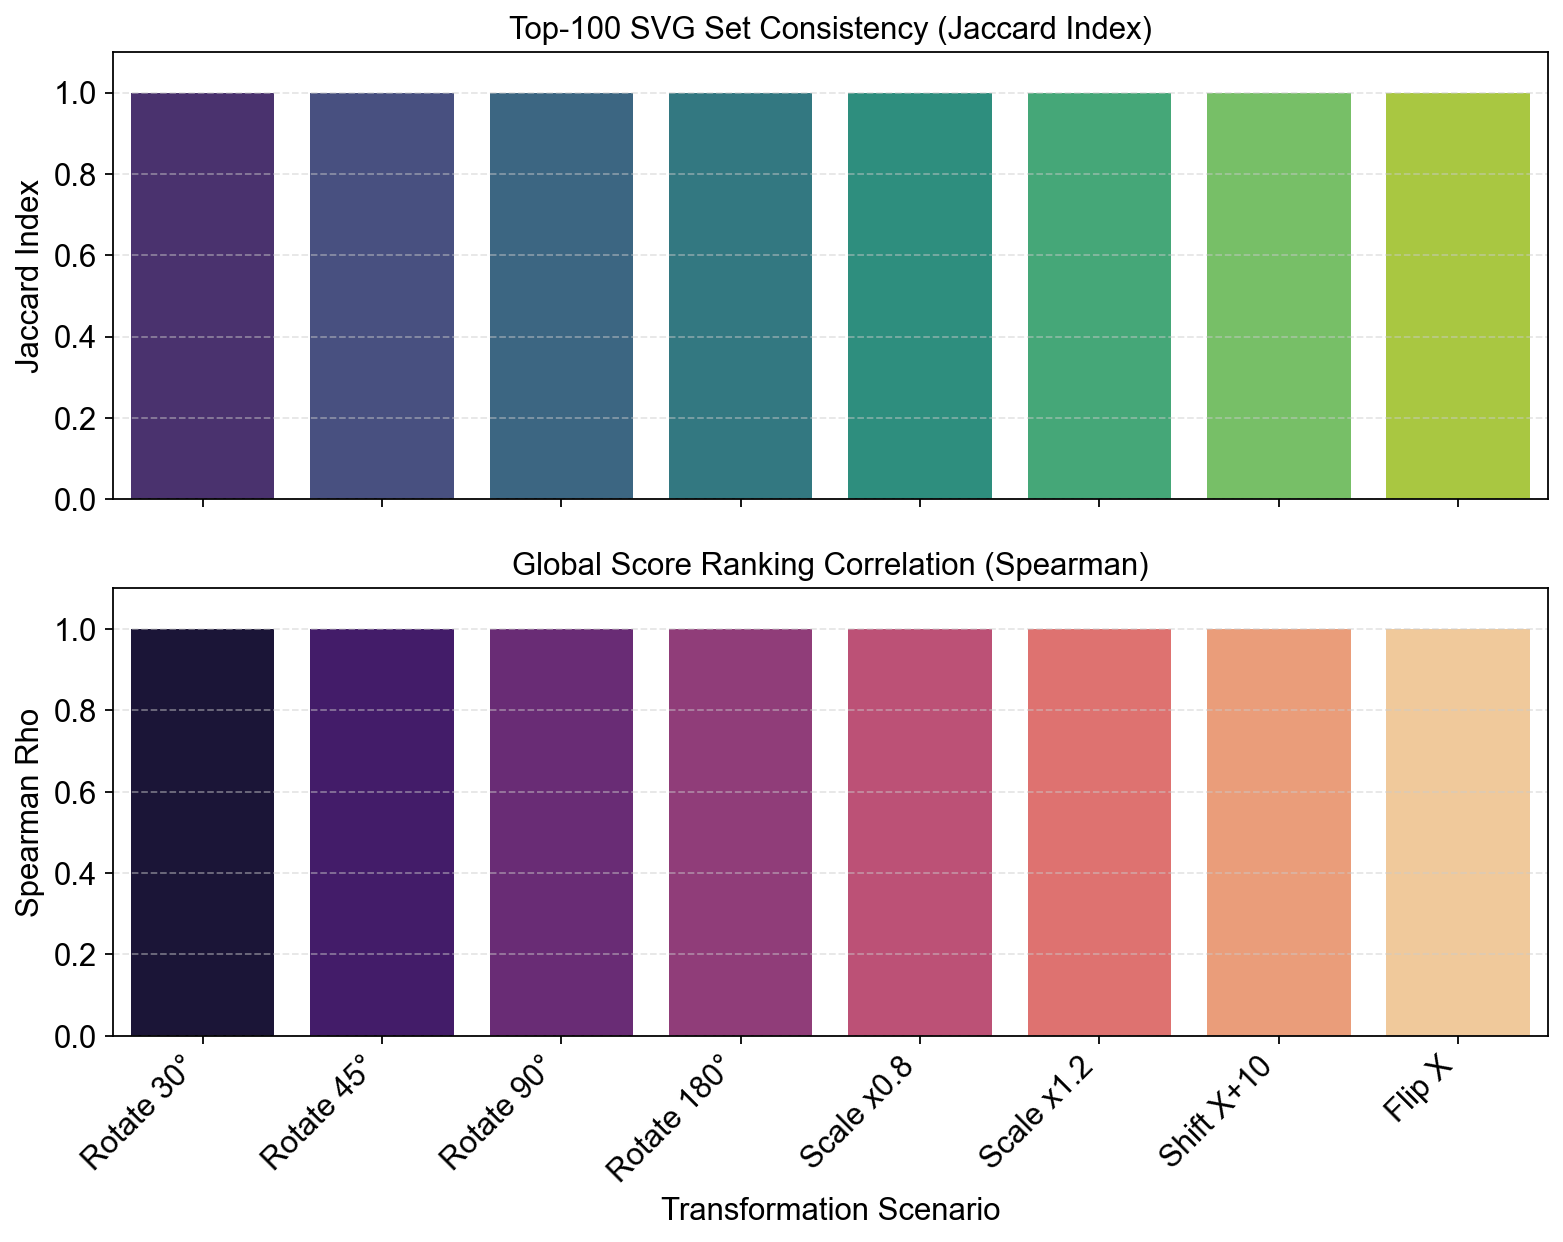

,name,angle,scaling,translation,flip,Jaccard,Spearman,Overlap
0,Rotate 30°,30,1.0,0,False,1.0,1.0,100
1,Rotate 45°,45,1.0,0,False,1.0,1.0,100
2,Rotate 90°,90,1.0,0,False,1.0,1.0,100
3,Rotate 180°,180,1.0,0,False,1.0,1.0,100
4,Scale x0.8,0,0.8,0,False,1.0,1.0,100
5,Scale x1.2,0,1.2,0,False,1.0,1.0,100
6,Shift X+10,0,1.0,"[10, 0]",False,1.0,1.0,100
7,Flip X,0,1.0,0,True,1.0,1.0,100


In [2]:
s1.run_stability_test(slide_id="Human_Breast_Andersson_10142021_ST_A1", 
                         tech="ST")

### Maynard

=== Stage 1: Transformation Stability Analysis | Slide: Human_Brain_Maynard_02082021_Visium_151676 ===
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 3460 spots x 33538 genes.

[INFO] Preprocessing AnnData...
[INFO] Preprocessing complete.

--- Running Baseline (Original Data) ---

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

Processing Scenario: Rotate 30°
  Params: Angle=30, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 0.9231 | Spearman: 0.9979

Processing Scenario: Rotate 45°
  Params: Angle=45, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 0.9608 | Spearman: 0.9990

Processing Scenario: Rotate 90°
  Params: Angle=90, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccar

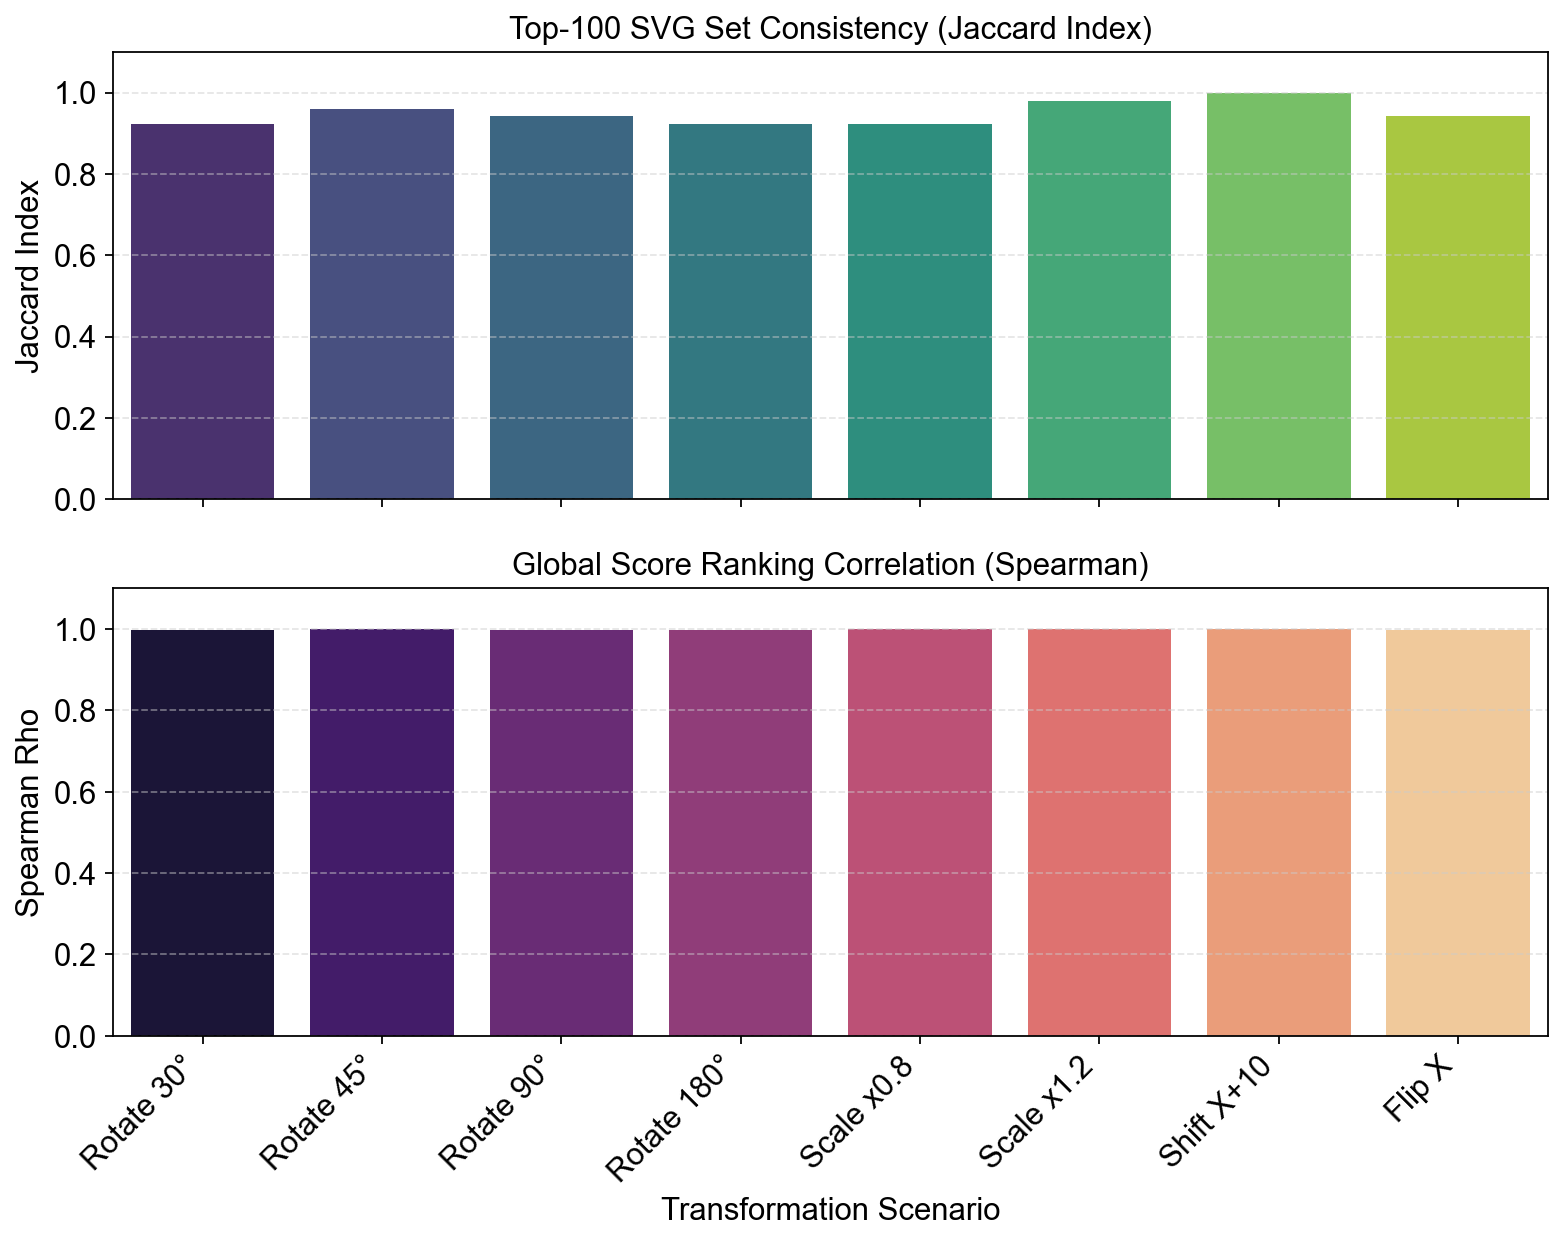

,name,angle,scaling,translation,flip,Jaccard,Spearman,Overlap
0,Rotate 30°,30,1.0,0,False,0.923077,0.997932,96
1,Rotate 45°,45,1.0,0,False,0.960784,0.998981,98
2,Rotate 90°,90,1.0,0,False,0.941748,0.998145,97
3,Rotate 180°,180,1.0,0,False,0.923077,0.997809,96
4,Scale x0.8,0,0.8,0,False,0.923077,0.999099,96
5,Scale x1.2,0,1.2,0,False,0.980198,0.999368,99
6,Shift X+10,0,1.0,"[10, 0]",False,1.000000,1.000000,100
7,Flip X,0,1.0,0,True,0.941748,0.998151,97


In [5]:
s1.run_stability_test(slide_id="Human_Brain_Maynard_02082021_Visium_151676",
                        tech = "Visium")

### Breast 10x

=== Stage 1: Transformation Stability Analysis | Slide: Human_Breast_10X_06092021_Visium ===
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 2518 spots x 17943 genes.

[INFO] Preprocessing AnnData...
[INFO] Preprocessing complete.

--- Running Baseline (Original Data) ---

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

Processing Scenario: Rotate 30°
  Params: Angle=30, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 0.9231 | Spearman: 0.9878

Processing Scenario: Rotate 45°
  Params: Angle=45, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 0.9231 | Spearman: 0.9872

Processing Scenario: Rotate 90°
  Params: Angle=90, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 0.9608 

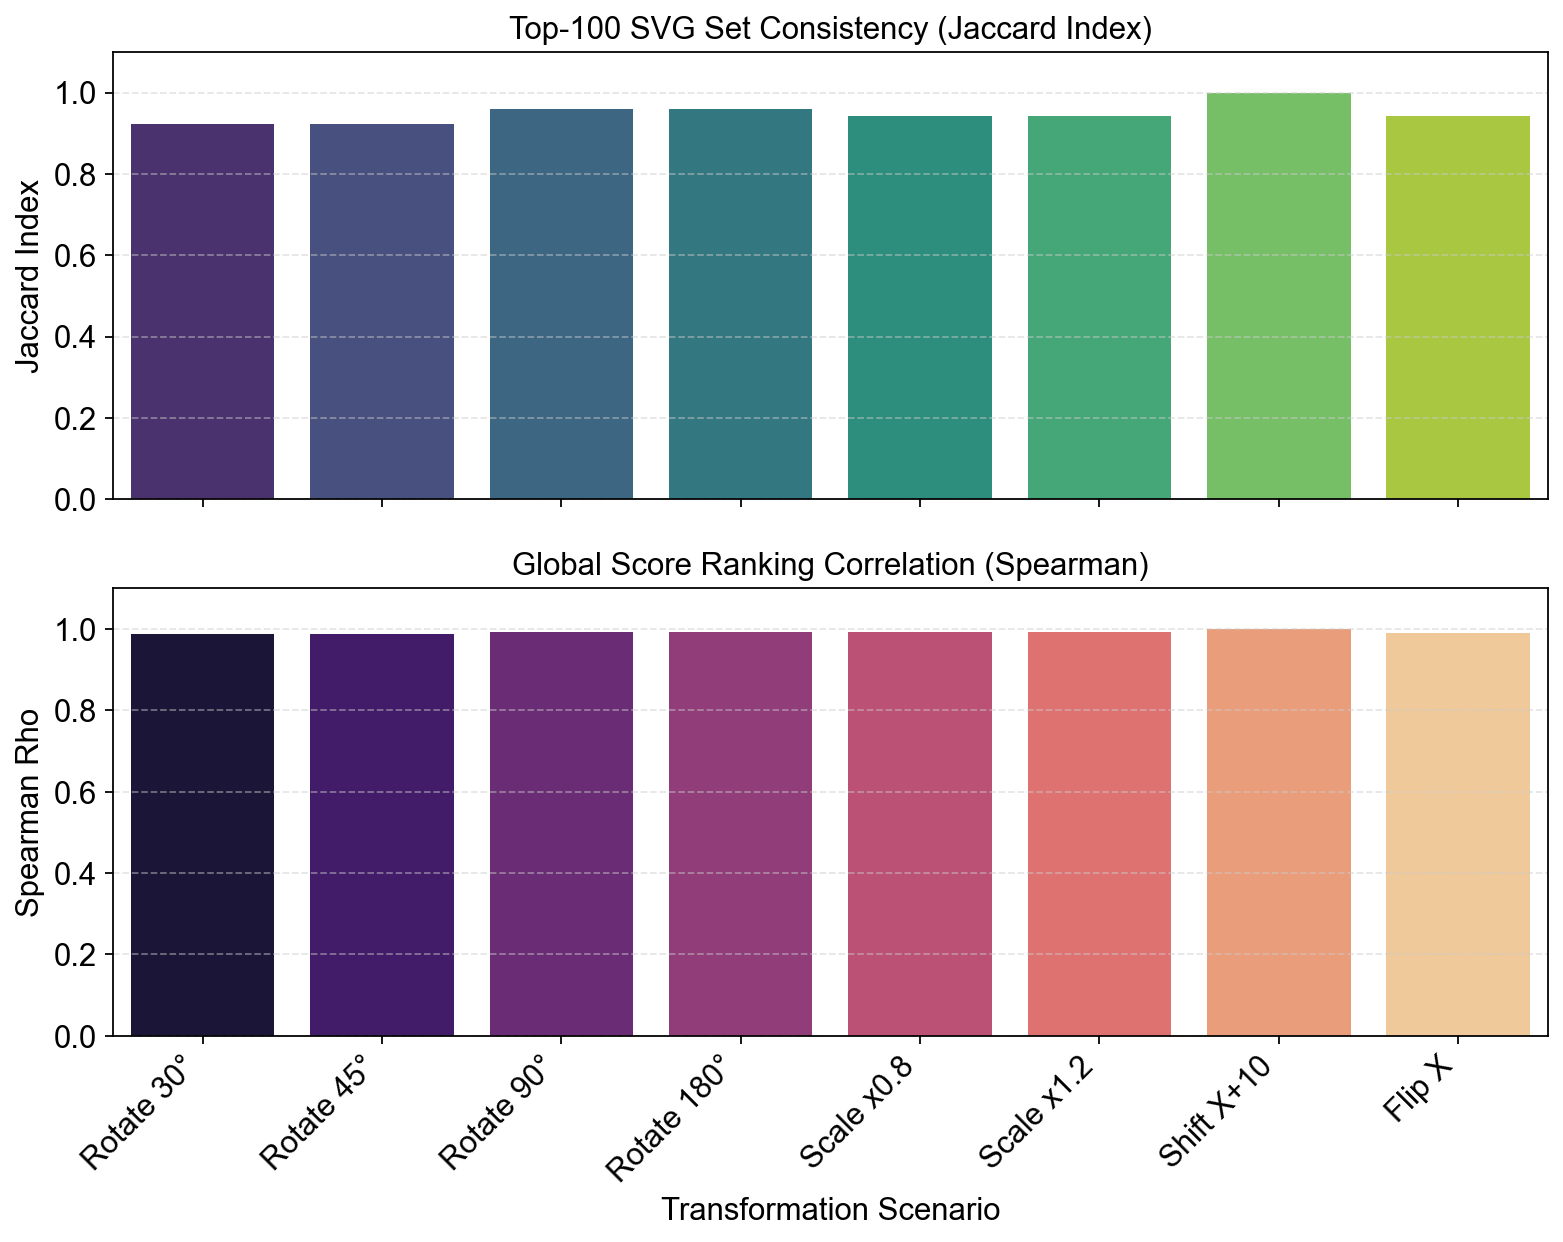

,name,angle,scaling,translation,flip,Jaccard,Spearman,Overlap
0,Rotate 30°,30,1.0,0,False,0.923077,0.987831,96
1,Rotate 45°,45,1.0,0,False,0.923077,0.987163,96
2,Rotate 90°,90,1.0,0,False,0.960784,0.993044,98
3,Rotate 180°,180,1.0,0,False,0.960784,0.993262,98
4,Scale x0.8,0,0.8,0,False,0.941748,0.993461,97
5,Scale x1.2,0,1.2,0,False,0.941748,0.992941,97
6,Shift X+10,0,1.0,"[10, 0]",False,1.000000,1.000000,100
7,Flip X,0,1.0,0,True,0.941748,0.991215,97


In [6]:
s1.run_stability_test(slide_id="Human_Breast_10X_06092021_Visium",
                        tech = "Visium")

### GS

=== Stage 1: Transformation Stability Analysis | Slide: GSE213688_GSM6592060 ===
[INFO] Loading CSVs and constructing AnnData...
[SUCCESS] AnnData object created: 1295 spots x 36601 genes.

[INFO] Preprocessing AnnData...
[INFO] Preprocessing complete.

--- Running Baseline (Original Data) ---

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.

Processing Scenario: Rotate 30°
  Params: Angle=30, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 0.9608 | Spearman: 0.9830

Processing Scenario: Rotate 45°
  Params: Angle=45, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 0.8868 | Spearman: 0.9811

Processing Scenario: Rotate 90°
  Params: Angle=90, Scale=1.0, Trans=0, Flip=False

[INFO] Running local SpaGFT implementation...
[INFO] Finished running local SpaGFT.
  -> Jaccard: 0.9417 | Spearman: 

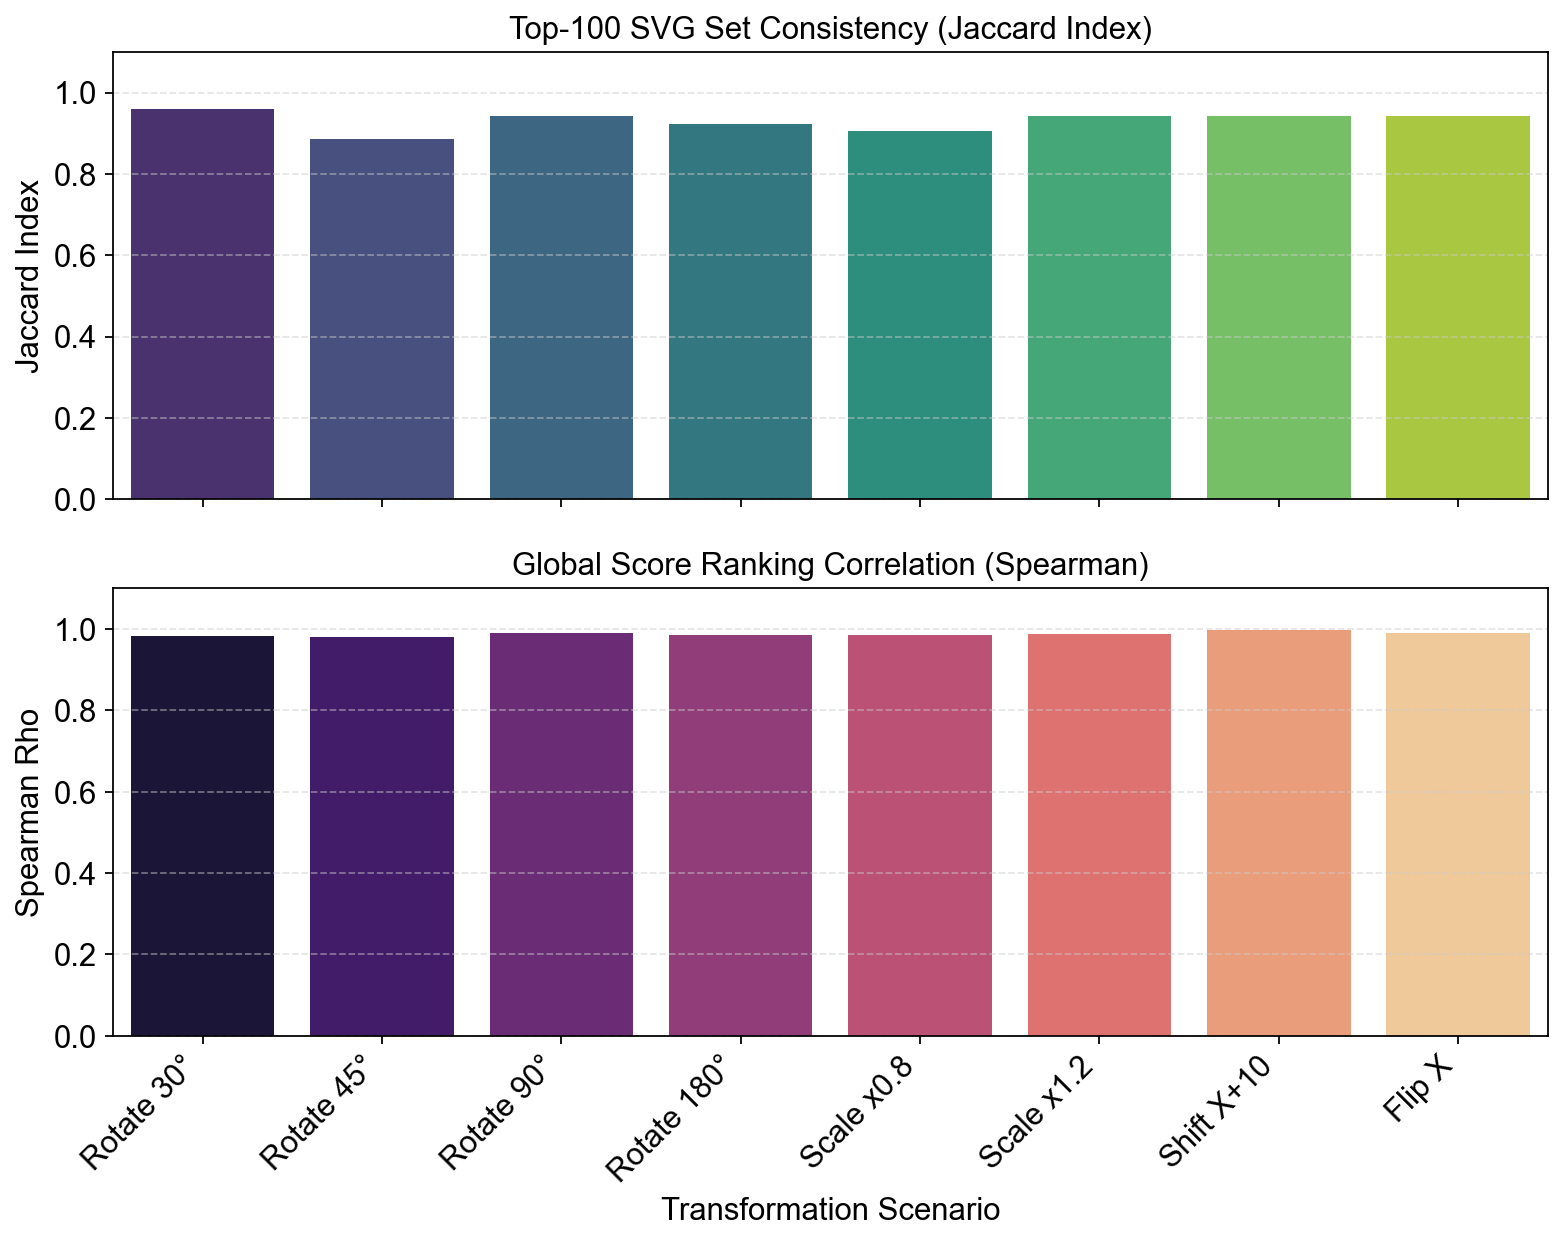

,name,angle,scaling,translation,flip,Jaccard,Spearman,Overlap
0,Rotate 30°,30,1.0,0,False,0.960784,0.983043,98
1,Rotate 45°,45,1.0,0,False,0.886792,0.981143,94
2,Rotate 90°,90,1.0,0,False,0.941748,0.990045,97
3,Rotate 180°,180,1.0,0,False,0.923077,0.984634,96
4,Scale x0.8,0,0.8,0,False,0.904762,0.985391,95
5,Scale x1.2,0,1.2,0,False,0.941748,0.987203,97
6,Shift X+10,0,1.0,"[10, 0]",False,0.941748,0.996424,97
7,Flip X,0,1.0,0,True,0.941748,0.989526,97


In [4]:
s1.run_stability_test(slide_id="GSE213688_GSM6592060",
                      tech = "Visium",
                      save_results=True)

### Flip X-axis

### Scaling